<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Risk Averse Gambler](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/06.04-Risk-Averse-Gambler.ipynb) | [Contents](toc.ipynb) | [Risk and Diversification](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.00-Risk-and-Diversification.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/06.05-Points-after-Touchdown-Decision.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/06.05-Points-after-Touchdown-Decision.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Points after Touchdown Decision

In American football, after scoring a touchdown for six points, a team runs one more play for a chance to score extra points. The team has the option to attempt to kick a field goal for one extra point or execute a touchdown play for two extra points. The one point kicking play is close to a 'sure thing' while the two point play normally succeeds on less than 50% of attempts. The lower success rate of the two point play makes it a risky option reserved for certain late game situtions.

This notebook implements a multi-stage decision model to determine conditions when a team should attempt the two point conversion. This model is adapted from

* Richard C. Porter, <a href=http://www.jstor.org/stable/2682653>Extra-Point Strategy in Football</a>. The American Statistician, Vol. 21, No. 5 (Dec., 1967), pp. 14-15.

* Harold Sackrowitz, <a href="https://stat.duke.edu/~dalene/chance/chanceweb/133.sackrowitz.pdf">Refining the Point(s)-After-Touchdown Decision</a>.  Chance, Vol. 13, pp. 29-34, 2000.

## Initializations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Multi-Stage Model of the Decision Process

The analysis is framed as a multi-stage decision process. Each stage corresponds to one team's possession of the football. The state of the game is monitored at the completion of each team's possession, but prior to the extra points decision. The state is modeled by three parameters:

* Outcome of the prior possession (S): Touchdown ('TD'), Field Goal ('FG'), or No Score ('NS')
* Point differential prior to extra point play (D)
* Number of remaining possessions (T)

The next cell enumerates values for each parameter. The set of possible states of the game is from as the product of these parameters which will be used as in index for subsequent calculations.

In [2]:
S = ['NS','FG','TD']
D = range(-100,100)
T = range(0,20)

idx = pd.MultiIndex.from_product([S,D,T],names = ['Score','Lead','Remaing Possessions'])

The model constructs probabilities for winning the game. For a given state (s,d,t), V[s,d,t] will represent the probability of winning following your own possession, and W[s,d,t] will represent the probability of winning following the opponent's possession.

In [3]:
V = pd.Series(index=idx)
W = pd.Series(index=idx)

To handle boundary condition it is helpful to initialize all of the probabilities prior to any calculations. We'll assume any tie results in a 50% probability of winning.

In [4]:
# initialize V and W for extreme values
for s,d,t in idx:
    if d < 0:
        V[s,d,t] = 0.0
        W[s,d,t] = 0.0
    elif d == 0:
        V[s,d,t] = 0.5
        W[s,d,t] = 0.5
    elif d > 0:
        V[s,d,t] = 1.0
        W[s,d,t] = 1.0

Variables to record decisions

In [5]:
P1 = pd.Series(index=pd.MultiIndex.from_product([D,T]))
P2 = pd.Series(index=pd.MultiIndex.from_product([D,T]))                                                                                                

### Transition Probabilities

Each possession leads to one of the following outcomes:

* Field Goal ('FG')
* Touchdown ('TD')
* No Score ('NS')

Following a touchdown, the scoring team can choose between

In [6]:
# probabilities
p = dict() 

p['FG'] = 0.12   # possession results in field goal
p['TD'] = 0.20   # possession results in touchdown
p['NS'] = 1.0 - p['FG'] - p['TD']  # possession results in no score

p['XP'] = 0.98   # extra point kick is successful
p['2P'] = 0.43   # two point attempt is successful

### Opponent's Decisions After the Last Possession

We'll assume the game ends on the opponent's last possession. That possession can end with no score, a field goal, or touchdown.  W[s,d,0] is probability of a win after the opponent's possession ends with outcome s and our lead is d, but before the opponent's decision regarding the point after play.  We assume the opponent will always go for a tie and over-time win if given the choice.

If the last possession ends in the opponent's touchdown to tie the game, assume the opponent will attempt an extra point for the win. If it fails then we can win in overtime with a probability of 1/2.

In [7]:
W['TD',0,0] = 0.5*(1.0 - p['XP'])

If the last possession ends in the opponent's touchdown to reduce the lead to one, assume the opponent will attempt an extra point to tie and go to overtime with probability p['XP']. Our team can with the game in regulation with probability `1-p['XP']` and in overtime with probability `p['XP']/2`.

In [8]:
W['TD',1,0] = (1.0 - p['XP']) + p['XP']/2.0

If the last possession ends in the opponent's touchdown to reduce the lead to two, assume the opponent will attempt a two point conversion to tie and go to overtime with probability p['2P']. Half of the time the opponent will then win the game, i.e., p['2P']/2. Thus

In [9]:
W['TD',2,0] = (1.0 - p['2P']) + p['2P']/2.0

#### Visualization

For the opponent to finish the final possession with a field goal or with no score makes the game a win if $d \geq 1$, a loss if $d \leq 1$, and an even chance if $d = 0$. A touchdown, however, reduces the chances for a win.  If $d=0$, then the only chance of a win is for the oppenent to miss the one point conversion  putting the game into overtime. If $d=1$, then the opponent has a roughly even change of winning in overtime. If $d=2$, then chances of a win improve further because the opponent must make a successful two point conversion and win in overtime. A three point or larger lead is insurmountable.

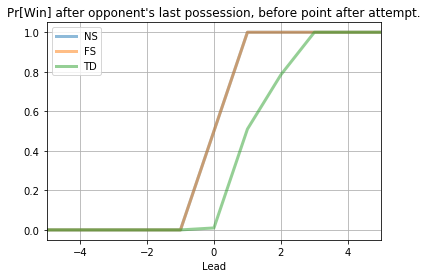

In [10]:
W['NS',:,0].plot(lw=3,label='NS',alpha=0.5)
W['FG',:,0].plot(lw=3,label='FS',alpha=0.5)
W['TD',:,0].plot(lw=3,label='TD',alpha=0.5)

plt.xlim(-5,5)
plt.legend()
plt.title("Pr[Win] after opponent's last possession, before point after attempt.")
plt.xlabel('Lead')
plt.grid()

### Decision Prior to the Opponent's Last Possession

Suppose the proponent scores a field goal or doesn't score on their last possession. The opponent will take possession, for which there will be three potential successor states. Successor states in which the opponent scores reduces our lead by the number of points scored.

On the other hand, if the proponent score a touchdown then there is a chance to score zero, one, or two extra points which add to the point differential. 

We compute the probability of a win if we attempt a win with either a one or two point conversion attempt, then choose the decision that maximizes the chance of a win.

In [11]:
for d in D[6:-6]:
    
    # probability of winning with 0, 1, 2 extra points followed by opponent outcome
    q0 = p['NS']*W['NS',d+0,0] + p['FG']*W['FG',d-3,0] + p['TD']*W['TD',d-6,0]
    q1 = p['NS']*W['NS',d+1,0] + p['FG']*W['FG',d-2,0] + p['TD']*W['TD',d-5,0]
    q2 = p['NS']*W['NS',d+2,0] + p['FG']*W['FG',d-1,0] + p['TD']*W['TD',d-4,0]
    
    V['NS',d,0] = q0
    V['FG',d,0] = q0
            
    P1[d,0] = p['XP']*q1 + (1-p['XP'])*q0         
    P2[d,0] = p['2P']*q2 + (1-p['2P'])*q0
                 
    V['TD',d,0] = max(P1[d,0],P2[d,0])

#### Visualization

Plotting the win probability shows impact of scoring a touchdown.

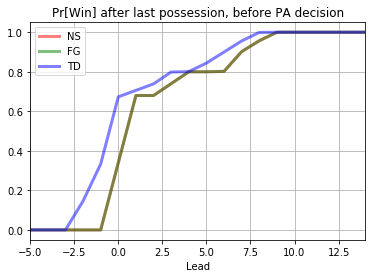

In [12]:
V['NS',:,0].plot(style='r',lw=3,alpha=0.5)
V['FG',:,0].plot(style='g',lw=3,alpha=0.5)
V['TD',:,0].plot(style='b',lw=3,alpha=0.5)

plt.xlim(-5,14)
plt.legend(S)
plt.title('Pr[Win] after last possession, before PA decision')
plt.xlabel('Lead')
plt.grid()

Subsequent stages of calculations begin with the outcome of the opponent's possession. The opponent is assumed to maximizes their probability of a win, which is equivalent to minimizing the proponent's probability of a win. 

The stage finishes with the outcome of the proponent's possession. If the outcome was a touchdown, the probability of wins are calculated for both the one and two point conversion attempts. These are recorded for later display. The proponent is assumed always choose the option that maximizes the propabability of a win.

In [13]:
for t in T[1:]:
    
    for d in D[6:-6]:
        q0 = p['NS']*V['NS',d+0,t-1] + p['FG']*V['FG',d+3,t-1] + p['TD']*V['TD',d+6,t-1]
        q1 = p['NS']*V['NS',d-1,t-1] + p['FG']*V['FG',d+2,t-1] + p['TD']*V['TD',d+5,t-1]
        q2 = p['NS']*V['NS',d-2,t-1] + p['FG']*V['FG',d+1,t-1] + p['TD']*V['TD',d+4,t-1]
        
        W['NS',d,t] = q0
        W['FG',d,t] = q0
        W['TD',d,t] = min(p['XP']*q1 + (1-p['XP'])*q0, p['2P']*q2 + (1-p['2P'])*q2)    
    
    for d in D[6:-6]:
        q0 = p['NS']*W['NS',d+0,t] + p['FG']*W['FG',d-3,t] + p['TD']*W['TD',d-6,t]
        q1 = p['NS']*W['NS',d+1,t] + p['FG']*W['FG',d-2,t] + p['TD']*W['TD',d-5,t]
        q2 = p['NS']*W['NS',d+2,t] + p['FG']*W['FG',d-1,t] + p['TD']*W['TD',d-4,t]
        
        V['NS',d,t] = q0
        V['FG',d,t] = q0
        P1[d,t] = (1-p['XP'])*q0 + p['XP']*q1
        P2[d,t] = (1-p['2P'])*q0 + p['2P']*q2
        V['TD',d,t] = max(P1[d,t],P2[d,t])

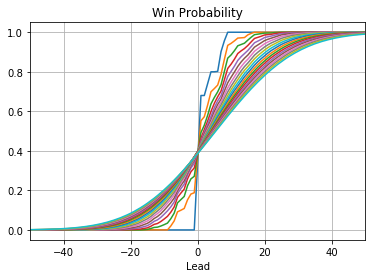

In [14]:
for t in T[0:]:
    V['NS',:,t].plot()

plt.xlim(-50,50)
plt.title('Win Probability')
plt.grid()

## Decision Chart

In [15]:
print("      Possessions Remaining ->")
print("Lead")

print("    ",end="")
for t in range(0,13):
    print("{0:3.0f} ".format(t),end="")
print("")

for d in range(-25,21):
    print("{0:3.0f} ".format(d),end="")
    for t in range(0,13):
        if (2 + 8*t + d >= 0) & (d <= 8*(t+1)) :
            if (P1[d,t] >= P2[d,t]):
                print("  . ",end="")
            else:
                print("  2 ",end="")
        else:
            print("    ",end="")
    print("")

      Possessions Remaining ->
Lead
      0   1   2   3   4   5   6   7   8   9  10  11  12 
-25               .   2   2   2   .   .   .   .   .   . 
-24               2   2   2   .   .   .   .   .   .   . 
-23               2   2   2   2   .   .   .   .   .   . 
-22               2   2   2   2   2   2   2   .   .   . 
-21               .   .   .   .   .   .   .   .   .   . 
-20               .   .   .   .   .   .   .   .   .   . 
-19               2   2   2   2   2   2   .   .   .   . 
-18           2   2   2   .   .   .   .   .   .   .   . 
-17           .   .   .   .   .   .   .   .   .   .   . 
-16           2   2   2   2   2   2   .   .   .   .   . 
-15           2   2   2   2   .   .   .   .   .   .   . 
-14           .   .   .   .   .   .   .   .   .   .   . 
-13           2   2   2   2   .   .   .   .   .   .   . 
-12           .   .   .   .   .   .   .   .   .   .   . 
-11           .   .   .   .   .   .   .   .   .   .   . 
-10       2   2   2   .   .   .   .   .   .   .   . 

## Odds of Winning

The calculations record the probability of winning for each decision assuming all subequent decisions by either team maximized their respective probabilities of a win.  

In [16]:
def prob2odds(p):
    if p <= 0.001:
        s = "{0:>7s}".format("1:{0:.0f}".format((1-p)/p))
    elif p <= 0.5:
        s = "{0:>7s}".format("1:{0:.1f}".format((1-p)/p))
    elif p <= 0.999:
        s = "{0:>7s}".format("{0:.1f}:1".format(p/(1-p)))
    else:
        s = "{0:>7s}".format("{0:.0f}:1".format(p/(1-p)))
    return s


print("Probability of a Win with Incremental Probability for 2 pt Attempt")
print("      Possessions Remaining ->")
print("Lead")

print("    ",end="")
for t in range(0,8):
    print("{0:7.0f} ".format(t),end="")
print("")

for d in range(-20,21):
    print("{0:3.0f} ".format(d),end="")
    for t in range(0,8):
        if (2 + 8*t + d >= 0) & (d <= 8*(t+1)) :
            P = max(P1[d,t],P2[d,t])
            if P1[d,t] > P2[d,t]:
                print("{0:>7s}*".format(prob2odds(P1[d,t])),end="")
            else:
                print("{0:>7s} ".format(prob2odds(P1[d,t])),end="")
        else:
            print("        ",end="")
    print("\n    ",end="")
    for t in range(0,8):
        if (2 + 8*t + d >= 0) & (d <= 8*(t+1)) :
            if P1[d,t] < P2[d,t]:
                print("{0:>7s}*".format(prob2odds(P2[d,t])),end="")
            else:
                print("{0:>7s} ".format(prob2odds(P2[d,t])),end="")
        else:
            print("        ",end="")
    print("\n")

Probability of a Win with Incremental Probability for 2 pt Attempt
      Possessions Remaining ->
Lead
          0       1       2       3       4       5       6       7 
-20                         1:437.5*1:148.3* 1:78.8* 1:51.2* 1:37.2*
                            1:438.6 1:149.0  1:79.2  1:51.5  1:37.5 

-19                         1:332.3 1:115.4  1:62.6  1:41.4  1:30.7 
                            1:309.8*1:110.3* 1:60.9* 1:40.8* 1:30.4*

-18                   1:inf 1:225.4  1:82.9  1:47.1* 1:32.3* 1:24.6*
                     1:1999*1:204.3* 1:82.2* 1:47.6  1:32.8  1:24.9 

-17                 1:876.6 1:136.5* 1:59.9* 1:36.3* 1:25.8* 1:20.1*
                    1:876.6 1:140.5  1:61.3  1:37.1  1:26.3  1:20.5 

-16                 1:380.6  1:94.4  1:45.9  1:29.1  1:21.2  1:16.8 
                    1:274.6* 1:82.7* 1:43.0* 1:28.2* 1:20.9* 1:16.8*

-15                 1:145.8  1:54.9  1:31.6  1:21.9  1:16.9* 1:13.8*
                    1:144.0* 1:54.5* 1:31.5* 1:21.9* 1:16.9  1:1

/Users/jeff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


## Analysis of Three Cases (To be completed)

### Northwestern at Notre Dame, 2014

### Notre Dame at Clemson, 2015

### Georgia Tech at Notre Dame, 2015

<!--NAVIGATION-->
< [Risk Averse Gambler](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/06.04-Risk-Averse-Gambler.ipynb) | [Contents](toc.ipynb) | [Risk and Diversification](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.00-Risk-and-Diversification.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/06.05-Points-after-Touchdown-Decision.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/06.05-Points-after-Touchdown-Decision.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>